In [7]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [8]:
IMAGE_SIZE = 256
BATCH_SIZE = 42
CHANNELS = 3

In [9]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "./savedModels/",
    seed=123,
    shuffle=True,
    image_size =(IMAGE_SIZE,IMAGE_SIZE),
    batch_size =BATCH_SIZE
)

Found 1317 files belonging to 2 classes.


In [10]:
class_names =dataset.class_names
class_names

['crop', 'weed']

In [11]:
len(dataset)

32

In [12]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(42, 256, 256, 3)
[1 1 1 1 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 1 0 1 0 0 1 0 1 0 0 1 1
 1 0 0 1 1]


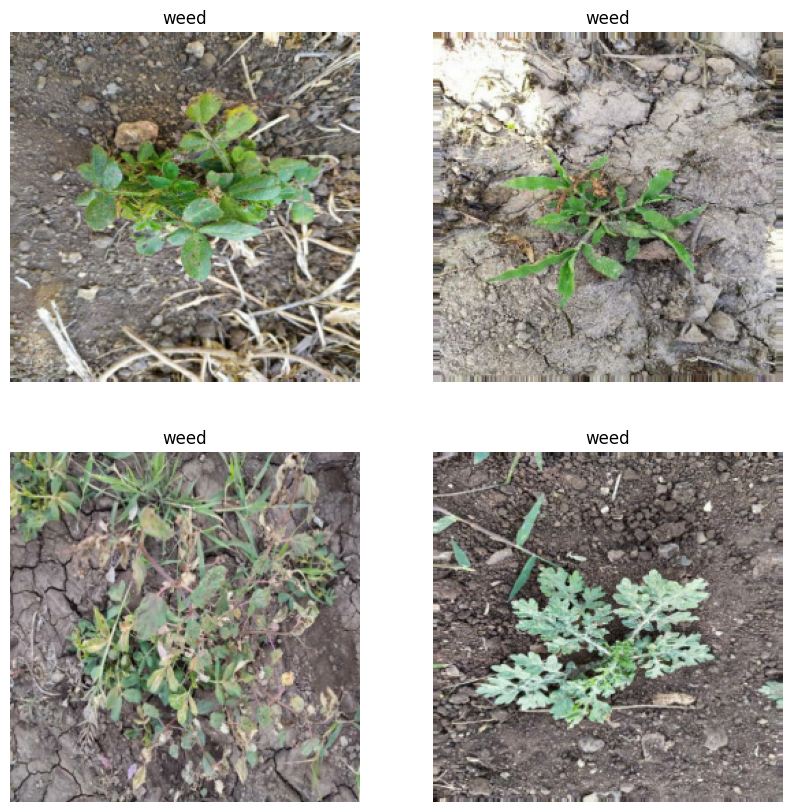

In [13]:
plt.figure(figsize=(10,10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(4):
        ax = plt.subplot(2,2,i+1)

        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [14]:
def get_dataset(ds ,train_split=0.8,val_split=0.1 , test_split=0.1,shuffle=True, shuffle_size =1000):
  assert(train_split+val_split+test_split)==1
  ds_size = len(ds)
  if shuffle:
    ds = ds.shuffle(shuffle_size,seed=12)

  train_size = int(train_split*ds_size)
  val_size = int (val_split*ds_size)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds
  train_ds, val_ds, test_ds = get_dataset(dataset)

In [15]:
train_ds, val_ds, test_ds = get_dataset(dataset)

In [16]:
len(train_ds)

25

In [17]:
len(val_ds)

3

In [18]:
len(test_ds)

4

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size =tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size =tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size =tf.data.AUTOTUNE)

In [20]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

In [21]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [22]:
train_ds = train_ds.map(
    lambda x,y: (data_augmentation(x,training=True),y)
).prefetch(buffer_size = tf.data.AUTOTUNE)

In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

n_classes =2

model = models.Sequential([
resize_and_rescale,
layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
layers.MaxPooling2D((2, 2)),
layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
layers.MaxPooling2D((2, 2)),
layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
layers.MaxPooling2D((2, 2)),
layers.Conv2D(64, (3, 3), activation='relu'),
layers.MaxPooling2D((2, 2)),
layers.Conv2D(64,(3, 3), activation='relu'),
layers.MaxPooling2D((2, 2)),
layers.Conv2D(64, (3, 3), activation='relu'),
layers.MaxPooling2D((2, 2)),
layers.Flatten(),
layers.Dense (64, activation='relu'),
layers.Dense (n_classes, activation='softmax'),

])

model.build(input_shape = input_shape)

In [24]:
from keras.applications import ResNet50

In [25]:
from keras.models import Sequential

In [26]:
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator

In [27]:
res = Sequential()
res.add(ResNet50(include_top=False, pooling='avg', weights="imagenet"))
res.add(Dense(n_classes, activation='softmax'))
res.layers[0].trainable = False

94765736/94765736 [==============================] - 28s 0us/step


In [28]:
res.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [29]:
res.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_2 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 23591810 (90.00 MB)
Trainable params: 4098 (16.01 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [31]:
history4 = res.fit(
    train_ds,
    batch_size =BATCH_SIZE,
    validation_data=val_ds,
    epochs=20
)

Epoch 1/20
25/25 [==============================] - 124s 5s/step - loss: 0.0625 - accuracy: 0.9829 - val_loss: 0.0291 - val_accuracy: 1.0000
Epoch 2/20
25/25 [==============================] - 116s 5s/step - loss: 0.0448 - accuracy: 0.9914 - val_loss: 0.0182 - val_accuracy: 1.0000
Epoch 3/20
25/25 [==============================] - 117s 5s/step - loss: 0.0374 - accuracy: 0.9933 - val_loss: 0.0130 - val_accuracy: 1.0000
Epoch 4/20
25/25 [==============================] - 116s 5s/step - loss: 0.0317 - accuracy: 0.9943 - val_loss: 0.0120 - val_accuracy: 1.0000
Epoch 5/20
25/25 [==============================] - 118s 5s/step - loss: 0.0279 - accuracy: 0.9943 - val_loss: 0.0094 - val_accuracy: 1.0000
Epoch 6/20
25/25 [==============================] - 120s 5s/step - loss: 0.0259 - accuracy: 0.9962 - val_loss: 0.0083 - val_accuracy: 1.0000
Epoch 7/20
25/25 [==============================] - 124s 5s/step - loss: 0.0215 - accuracy: 0.9971 - val_loss: 0.0069 - val_accuracy: 1.0000
Epoch 8/20
25

In [32]:
scores =res.evaluate(test_ds)

4/4 [==============================] - 18s 4s/step - loss: 0.0375 - accuracy: 0.9940


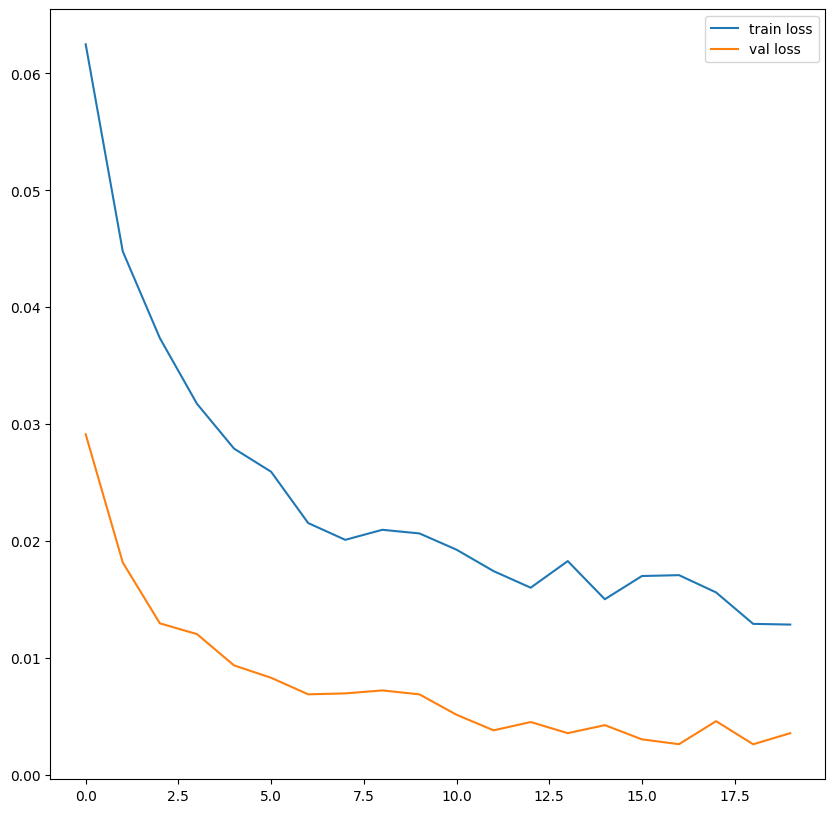

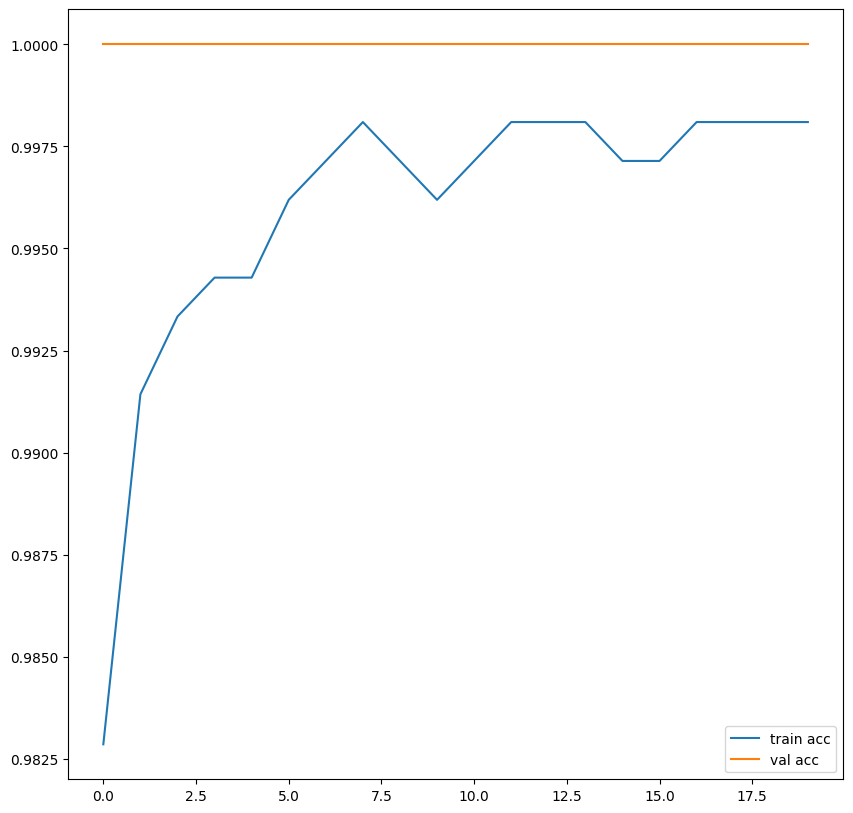

In [33]:
plt.figure(figsize=(10,10))
plt.plot(history4.history['loss'], label='train loss')
plt.plot(history4.history['val_loss'], label='val loss')
plt.legend()
plt.show()

plt.figure(figsize=(10,10))
plt.plot(history4.history['accuracy'], label='train acc')
plt.plot(history4.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [34]:
def predict (res, img):
    img_array2 = tf.keras.preprocessing.image.img_to_array(images2[i].numpy())
    img_array2 = tf.expand_dims (img_array2, 0)
    predictions2 = res.predict(img_array2)
    predicted_class2 = class_names[np.argmax (predictions2[0])]
    confidence2 = round(100* (np.max(predictions2[0])), 2)
    return predicted_class2, confidence2

1/1 [==============================] - 0s 151ms/step


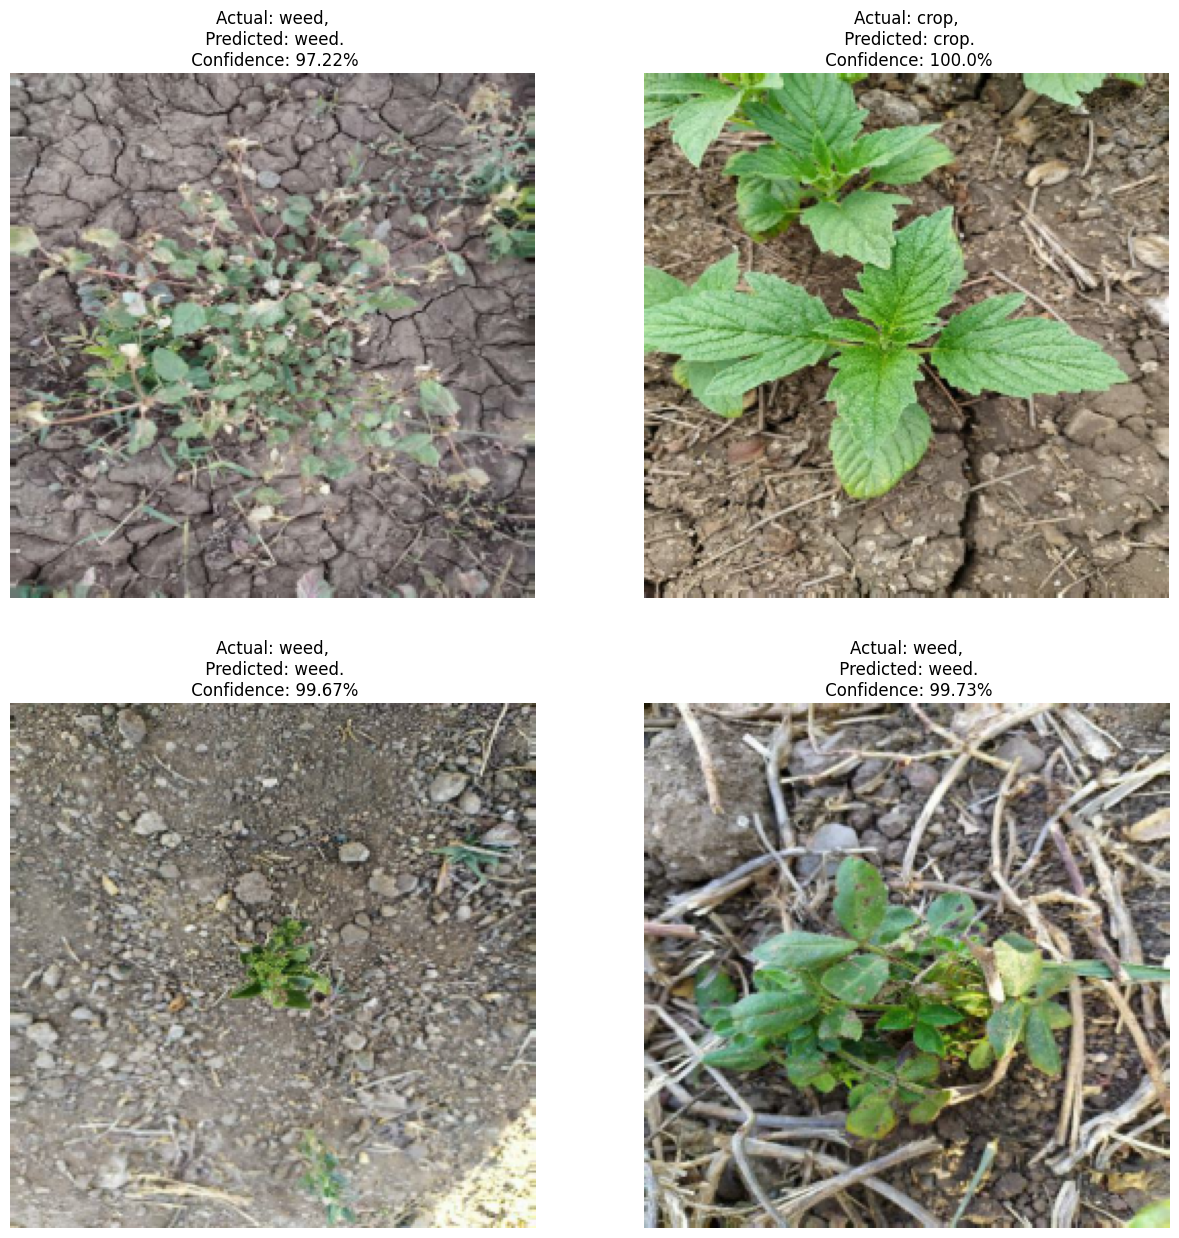

In [35]:
plt.figure(figsize=(15, 15))
for images2, labels2 in test_ds.take(1):

  for i in range(4):

    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(images2[i].numpy().astype("uint8"))

    predicted_class2, confidence2= predict(res, images2[i].numpy())
    actual_class2 = class_names[labels2[i]]
    plt.title(f"Actual: {actual_class2},\n Predicted: {predicted_class2}.\n Confidence: {confidence2}%")
    plt.axis("off")